# Setup
Firstly, we load all the necessary packages used in this notebook and define some settings for visualizing the input image data. If you encounter `ModuleNotFoundError`, please install the corresponding package using `pip install` or `conda install`.

In [1]:
# Copyright 2021 ETH Zurich and University of Bologna.
# Licensed under the Apache License, Version 2.0, see https://www.apache.org/licenses/LICENSE-2.0 for details.
# SPDX-License-Identifier: Apache-2.0

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
import seaborn as sn
import os
import logging
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import pathlib

# set global seeds for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

# Setting parameters for plotting
plt.rcParams['figure.figsize'] = (15.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

logging.getLogger("tensorflow").setLevel(logging.DEBUG)

print("TensorFlow version: ", tf.__version__)
%matplotlib inline

TensorFlow version:  2.11.1


In [2]:
# check if GPU is available
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is available


# Task 1

### Download the dataset
For this we use the keras.datasets.mnist package. This package contains the Fashion-MNIST dataset which is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. This dataset can be used as a drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

In [3]:
# Load Fashion-Mnist dataset, we can use Tensorflow for this
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# we save the pixels before normalization for plotting
train_images_float = train_images.astype(np.float32)
test_images_float = test_images.astype(np.float32)

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

print("Shape of train dataset: {}".format(train_images.shape))
print("Shape of train labels: {}".format(train_labels.shape))
print("Shape of test dataset: {}".format(test_images.shape))
print("Shape of test labels: {}".format(test_labels.shape))

Shape of train dataset: (60000, 28, 28)
Shape of train labels: (60000,)
Shape of test dataset: (10000, 28, 28)
Shape of test labels: (10000,)


### Visualize the data
We can visualize the data by plotting 5 samples of each class. We can see that the images are in grayscale format. 

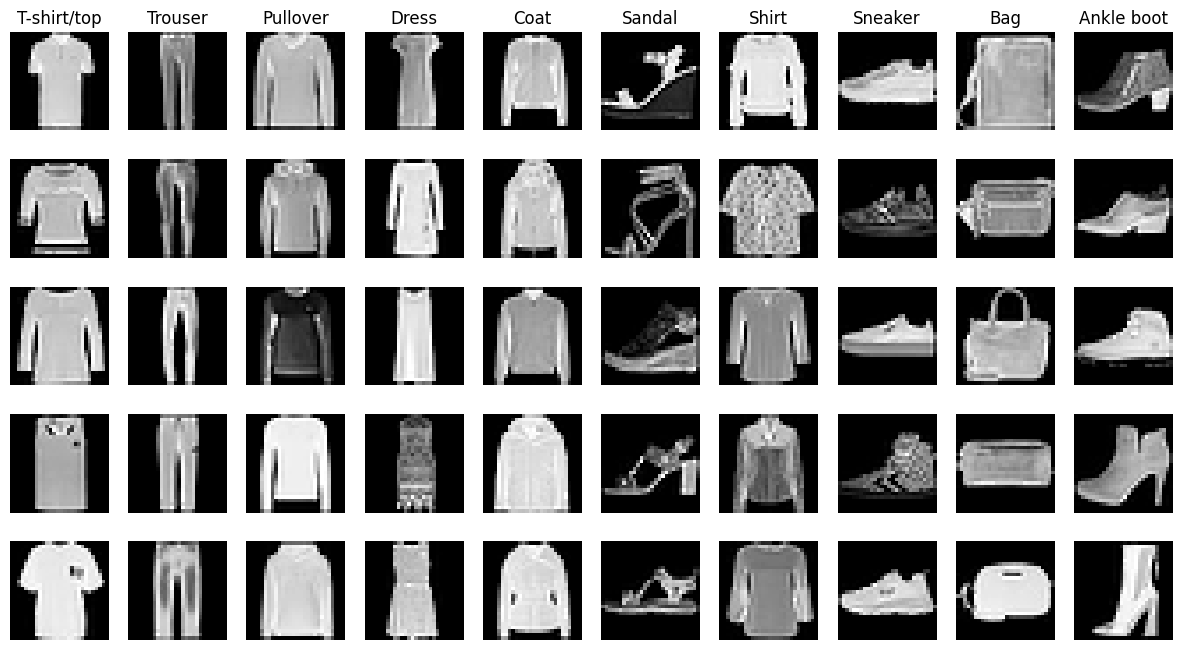

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(train_labels == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(train_images_float[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### Create the Keras model
The input data is in the range of [0, 255]. We need to rescale the input data to the range of [0, 1] before feeding it to the model because the model should train on normalized and standardized data. We can do this by dividing the input data by 255. Thus, we ensure that all features are in the same range. We create a simple Keras model with one convolutional layers and a dense layer. The model is compiled with the Adam optimizer and the categorical cross-entropy loss function.

In [5]:
# Define the model architecture (version 1 - simple model)
fp_model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

In [6]:
# Compile the model
fp_model.compile(optimizer='adam',
                # the loss function is the sparse categorical cross-entropy
                # loss. It is used when there are two or more label classes. 
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [7]:
# View the model summary
fp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 12)        120       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 12)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2028)              0         
                                                                 
 dense (Dense)               (None, 10)                20290     
                                                                 
Total params: 20,410
Trainable params: 20,410
Non-trainable params: 0
____________________________________________________

In [3]:
# Train the model (this will take a while)
# The early stopping (es) callback will stop the training when the validation loss stops improving
es = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = fp_model.fit(
    train_images,
    train_labels,
    epochs=5,
    validation_data=(test_images, test_labels),
    callbacks=[es]
)

NameError: name 'tf' is not defined

In [2]:
!export XLA_FLAGS=--xla_gpu_cuda_data_dir=/home/master/.conda/envs/sc/pkgs/cuda-toolkit

In [36]:
# save the model so we can use it later
# without having to retrain it

# check if 'model' directory exists
if not os.path.exists('models'):
    os.makedirs('models')
fp_model.save('models/fmnist_model_f32.h5')

In [37]:
# Evaluate the model on the test set
fp_test_loss, fp_test_acc = fp_model.evaluate(test_images,  test_labels, verbose=2)
print('Test accuracy:', fp_test_acc)
print('Test loss:', fp_test_loss)

313/313 - 0s - loss: 0.2960 - accuracy: 0.8929 - 307ms/epoch - 980us/step
Test accuracy: 0.8928999900817871
Test loss: 0.2960303723812103


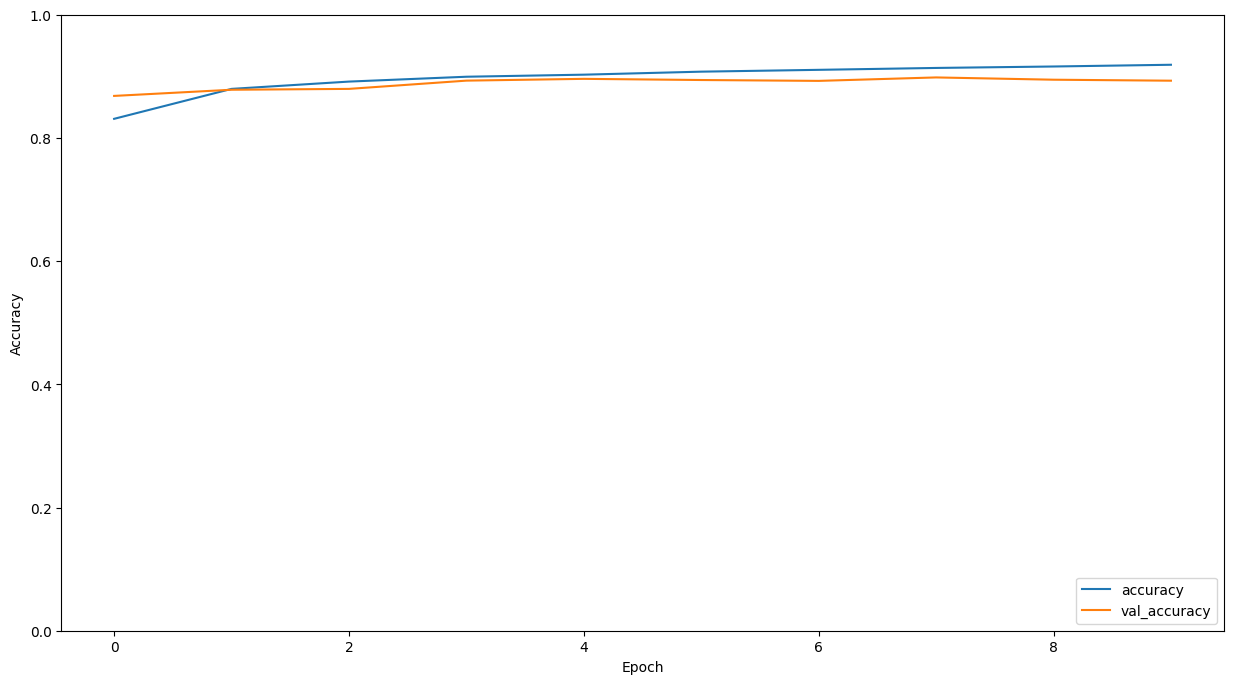

In [38]:
# Plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

# Evaluate the accuracy via a confusion matrix
We can evaluate the accuracy of the model by plotting a confusion matrix. The confusion matrix shows the ratio of correct and incorrect predictions for each class.

In [39]:
# plot the confusion matrix for the quantized model
from sklearn.metrics import confusion_matrix
import itertools

"""
function: plot_confusion_matrix
    - input: cm, classes, normalize, title, cmap
    - output: none
    - description: plots the confusion matrix
"""

def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

313/313 [==============================] - 0s 871us/step
Confusion matrix, without normalization
[[867   0  20  27   5   1  71   0   9   0]
 [  4 975   1  16   1   0   3   0   0   0]
 [ 15   1 907   8  33   0  36   0   0   0]
 [ 16   6  18 916  17   0  25   0   2   0]
 [  3   0 137  37 778   0  45   0   0   0]
 [  0   0   0   1   0 974   0  16   0   9]
 [151   1 113  31  62   0 634   0   8   0]
 [  0   0   0   0   0  18   0 926   1  55]
 [  6   2   5   2   2   2   3   4 974   0]
 [  0   0   0   0   0   7   1  14   0 978]]


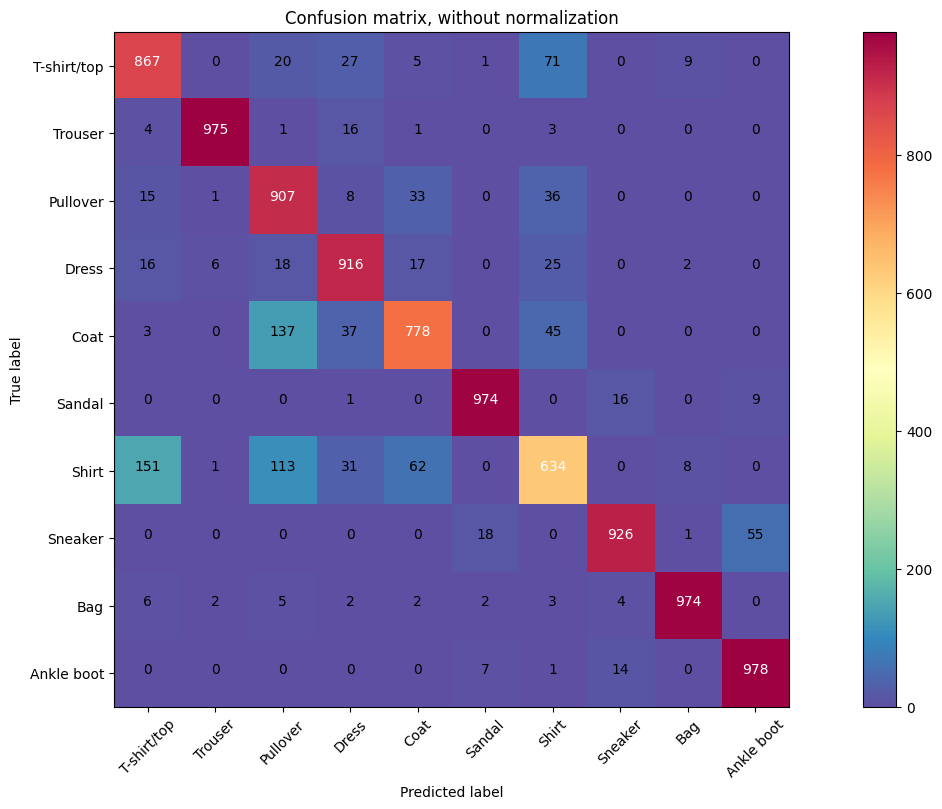

In [40]:
cm = confusion_matrix(test_labels, np.argmax(fp_model.predict(test_images), axis=-1))
plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

# Convert the keras model to a tflite model
We can convert the keras model to a tflite model by using the `tf.lite.TFLiteConverter.from_keras_model_file()` function. After converting the model, we can save it to a file. Furthermore, we compare the size of the keras model and the tflite model. The difference is due to the fact that we have a lot of metadata in the keras model which is not present in the tflite model, such as the model architecture, optimizer, loss function, etc. This is also why you cannot call the `model.summary()` function on the tflite model.

In [41]:
# Convert the model to TFLite without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(fp_model)
fp_tflite_model = converter.convert()

# Save the model to disk
open("models/fmnist_model_f32.tflite", "wb").write(fp_tflite_model)

# Show the model size for the non-quantized HDF5 model
fp_h5_in_kb = os.path.getsize('models/fmnist_model_f32.h5') / 1024
print("HDF5 Model size without quantization: %d KB" % fp_h5_in_kb)

# Show the model size for the non-quantized TFLite model
fp_tflite_in_kb = os.path.getsize('models/fmnist_model_f32.tflite') / 1024
print("TFLite Model size without quantization: %d KB" % fp_tflite_in_kb)

# Determine the reduction in model size
print("\nReduction in file size by a factor of %f" % (fp_h5_in_kb / fp_tflite_in_kb))

INFO:tensorflow:Assets written to: /tmp/tmp7otztfzy/assets


INFO:tensorflow:Assets written to: /tmp/tmp7otztfzy/assets


HDF5 Model size without quantization: 265 KB
TFLite Model size without quantization: 82 KB

Reduction in file size by a factor of 3.208066


2023-04-03 20:24:36.196130: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-04-03 20:24:36.196154: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-04-03 20:24:36.199649: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-04-03 20:24:36.217880: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7otztfzy
2023-04-03 20:24:36.222898: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { serve }; Status: success: OK. Took 26643 microseconds.
